In [134]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import requests

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Retrieve Data from API

In [67]:
# Define the tags
tags = {
    'Software Development': ['html', 'css', 'javascript', 'react', 'typescript', 'php', 'react', 'laravel', 'node.js', 'kotlin;java', 'swift', 'sql', 'flask', 'django', 'flutter', 'react-native', 'bootstrap', 'tailwind', 'git'],
    'Data Science and Artificial Intelligence': ['python', 'r', 'sql', 'pandas', 'numpy', 'apache-spark', 'hadoop', 'machine-learning', 'deep-learning', 'tensorflow', 'keras', 'pytorch', 'scikit-learn', 'spacy', 'nltk', 'matplotlib', 'seaborn'],
    'Internet of Things': ["iot", "aws-iot", "azure-iot-hub", "google-cloud-iot", "ibm-watson-iot", "node-red", "kafka", "mqtt", "coap", "lora", "lorawan", "zigbee", "rfid", "raspberry-pi", "arduino", "esp8266", "esp32", "microcontroller", "raspbian", "grafana", 'embedded']
}

reversed_tag = {}
for k, v in tags.items():
    for item in v:
        reversed_tag[item] = k

In [ ]:
# Create a function to fetch data from API
def fetch_data(params):
    url = 'https://api.stackexchange.com/2.3/questions'
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
        else:
            data = {}
            response.raise_for_status()
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error occurred: {err}") 
    except requests.exceptions.RequestException as e:
        print(f"Other error occurred: {e}")  
        
    
    return data

In [ ]:
# Fetching data from API
data = []
for i in tags.keys():
    for j in tags[i]:
        for k in [1,2]:
            data.append([fetch_data(
                params= {
                    'page': k,
                    'pagesize': 100 if int(3000/len(tags[i])) > 100 else int(3000/len(tags[i])),
                    'order': 'desc',
                    'sort': 'votes',
                    'tagged': j,
                    'site': 'stackoverflow'
                }), i]
            )

KeyboardInterrupt: 

In [ ]:
# Convert retrieved data (JSON) to Python list
df = []
for i in data:
    for j in i[0]['items']:
        df.append([j['title'], j['tags'], i[1]])

In [ ]:
# Convert Python list to dataframe
df = pd.DataFrame(df, columns=['question', 'tags', 'label'])

In [71]:
# Save the data (dataframe) to excel
df.to_excel('question.xlsx', index=False)

## Text Classification

### Read Data

In [127]:
df = pd.read_excel('Question.xlsx')
df.head()

,question,tags,label
0,Why does HTML think “chucknorris” is a color?,"['html', 'browser', 'background-color']",Software Development
1,How can I validate an email address in JavaScr...,"['javascript', 'html', 'regex', 'email-validat...",Software Development
2,How do I check whether a checkbox is checked i...,"['javascript', 'jquery', 'html', 'checkbox']",Software Development
3,How can I horizontally center an element?,"['html', 'css', 'alignment', 'centering']",Software Development
4,Which &quot;href&quot; value should I use for ...,"['javascript', 'html', 'performance', 'optimiz...",Software Development


### Exploratory Data Analysis

In [128]:
# Check empty string in question column
(df['question'] == '').sum()

0

In [129]:
# Check missing values
df.isna().sum()

question    0
tags        0
label       0
dtype: int64

<BarContainer object of 3 artists>

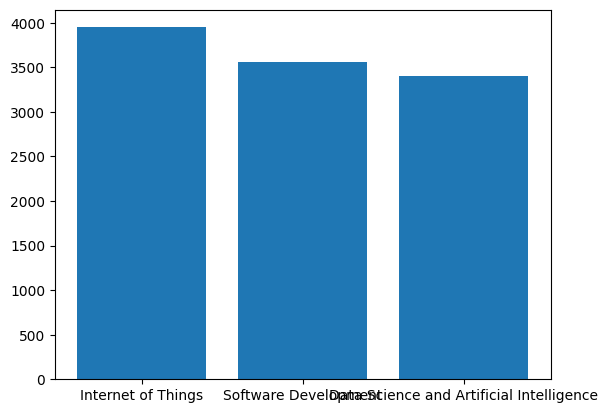

In [130]:
plt.bar(df['label'].value_counts().index, df['label'].value_counts())

### Data Preprocessing

In [140]:
X = df['question']
y = df['label']

# Perform label encoder to the target feature (label)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Train Models

In [147]:
models = [
    {
        'model': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
            ('nb', GaussianNB())
        ]),
        'params': {}
    },
    {
        'model': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('dt', DecisionTreeClassifier())
        ]),
        'params': {
            'dt__max_depth': [3, 5, 10, None],
            'dt__min_samples_split': [2, 5, 10],
            'dt__criterion': ['gini', 'entropy'],
            'dt__max_leaf_nodes': [None, 10, 20],
        }
    },
    {
        'model': Pipeline([
            ('tfidf', TfidfVectorizer()),
            ('svm', SVC())
        ]),
        'params': {}
    }
]

cv = KFold(n_splits=5, random_state=42, shuffle=True)

In [141]:
scores = []
for i in models:
    clf = GridSearchCV(i['model'],i['params'],cv=5,return_train_score=False)
    clf.fit(X_train,y_train)
    scores.append({
        'model':str(i['model']).replace('()',''),
        'best_score':clf.best_score_,
        'best_params':clf.best_params_
    })

In [ ]:
# SVM get the highest score / accuracy (89%)
scores

[{'model': "Pipeline(steps=[('tfidf', TfidfVectorizer),\n                ('dense',\n                 FunctionTransformer(accept_sparse=True,\n                                     func=<function <lambda> at 0x000001E500A5E0E0>)),\n                ('nb', GaussianNB)])",
  'best_score': 0.8217059765409369,
  'best_params': {}},
 {'model': "Pipeline(steps=[('tfidf', TfidfVectorizer), ('dt', DecisionTreeClassifier)])",
  'best_score': 0.8105758648000905,
  'best_params': {'dt__criterion': 'entropy',
   'dt__max_depth': None,
   'dt__max_leaf_nodes': None,
   'dt__min_samples_split': 2}},
 {'model': "Pipeline(steps=[('tfidf', TfidfVectorizer), ('svm', SVC)])",
  'best_score': 0.8942274658245817,
  'best_params': {}}]

### Best Model Prediction

In [152]:
best_model = models[2]['model']
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

In [156]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1019
           1       0.93      0.93      0.93      1175
           2       0.87      0.88      0.88      1080

    accuracy                           0.90      3274
   macro avg       0.90      0.90      0.90      3274
weighted avg       0.90      0.90      0.90      3274



In [157]:
print(confusion_matrix(y_test, y_pred))

[[ 905   29   85]
 [  30 1091   54]
 [  75   55  950]]


In [159]:
accuracy_score(y_pred, y_test)

0.8998167379352474

### Test Using Own Data

In [ ]:
# Let's try with our data
text = ["I'm trying to define NN model with Pytorch but there's a type error when I wanted to to convert y-train to y-train-tensor What should I do to fix it?"]
print(encoder.inverse_transform(best_model.predict((text))))

['Data Science and Artificial Intelligence']
